## We select the attribute "number of days since the pop-up store opened"

In [221]:
import sqlite3
import pandas as pd
from statistics import stdev, mean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import math


In [222]:
# connect to splite
con = sqlite3.connect("cafe_insomnia.sqlite")

In [223]:
# read tables from sqlite
Transaction = pd.read_sql_query("SELECT * from ci_transaction", con)
Drinks = pd.read_sql_query("SELECT * from drink", con)
Areas = pd.read_sql_query("SELECT * from study_area", con)
con.close()

## Data preview

In [224]:
Transaction.head()

,id,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id
0,0,2019-07-22,0,Mon,0,5,1,No,3
1,1,2019-07-22,0,Mon,0,5,1,No,1
2,2,2019-07-22,0,Mon,0,2,1,No,5
3,3,2019-07-22,0,Mon,0,2,1,No,6
4,4,2019-07-22,0,Mon,0,5,1,No,5


In [225]:
Drinks.head()

,id,name,unit_price
0,0,Espresso,3.5
1,1,Ristretto,3.3
2,2,Macchiato,3.8
3,3,Long Black (L),4.0
4,4,Long Black (S),3.8


In [226]:
Areas.head()

,id,name,dist_to_cafe
0,0,Fisher Library (F03),70
1,1,Law Library (F10),84
2,2,The Quarter (A16),400
3,3,Abercrombie (H70),700
4,4,Brennan MacCallum (A18),350


## Data processing

In [227]:
# store drinks' information in dictionary
drink_price_getter = {}
all_drinks = {}

for index, row in Drinks.iterrows():
    drink_id = row['id']
    drink_unitprice = row['unit_price']
    drink_price_getter[drink_id] = drink_unitprice
    all_drinks[drink_id] = row['name']

In [228]:
day_sales = {}
drinks_day_sales = {}

for index, row in Transaction.iterrows():
    # compute sales of each day
    day = row['days_after_open']
    quality = row['quantity']
    drink = row['drink_id']
    unit_price = drink_price_getter[drink]
    if day not in day_sales:
        day_sales[day] = 0
    day_sales[day] += unit_price * quality

    # compute sales of each day group by drinks
    if drink not in drinks_day_sales:
        drinks_day_sales[drink] = {}
    if day not in drinks_day_sales[drink]:
        drinks_day_sales[drink][day] = 0
    drinks_day_sales[drink][day] += unit_price * quality

## Compute and draw the ditribution of daily sales

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

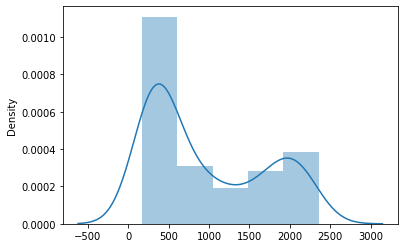

In [229]:
# draw the sales distribution
keys = list(day_sales.keys())
values = list(day_sales.values())

sns.distplot(values)

## Compute and draw the trend of daily sales

Text(95, 2259.8000000000006, '135th day')

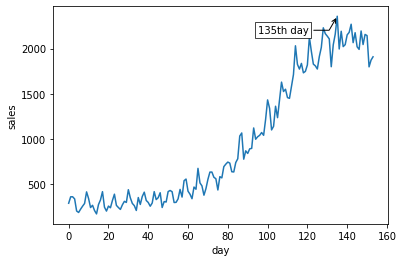

In [230]:
plt.plot(keys, values)
plt.xlabel("day")
plt.ylabel("sales")

max_sales = max(values)
# add maximum label in figure
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
kw = dict(xycoords='data',textcoords="data", arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
plt.annotate(str(values.index(max_sales)) + 'th day', xy=(values.index(max_sales), max_sales), xytext=(values.index(max_sales) - 40, max_sales - 100),  **kw)

According to the above figure, it is clear that the Coffee shop sales are increasing day by day, until the 135th day. After the 135th day, the sales gradually stabilized. Next, we try to explore what factors may affect the sales.

In [238]:
# compute the grow rate of sales
grow_list = []
avg_grow_list = []
sales = list(day_sales.values())

for i in range(1, len(sales)):
    grow = sales[i] / sales[i-1]
    grow_list.append(grow)

for i in range(len(grow_list) - 2):
    avg_grow = (grow_list[i] + grow_list[i+1] + grow_list[i+2]) / 3
    avg_grow_list.append(avg_grow)

Text(0, 0.5, 'grow rate')

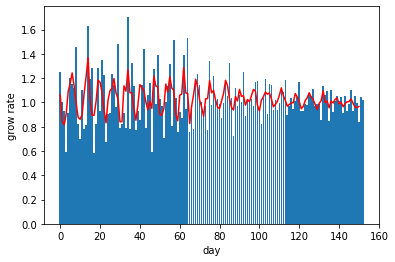

In [239]:
# plot the grow rate of sales
y_pos = np.arange(len(grow_list))
plt.bar(y_pos, grow_list)
plt.plot(avg_grow_list, color='red')
plt.xlabel("day")
plt.ylabel("grow rate")

We also check the growth rate of sales during these days, the growth rate keeps decreasing and approaching 0.

## compute and draw the trend of daily sales group by different drinks

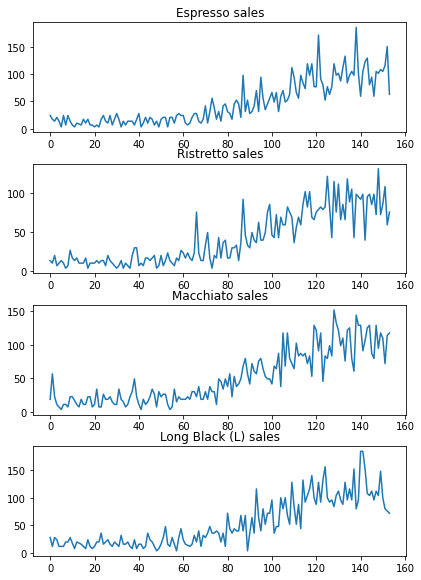

In [231]:
# draw the sales change group by drinks
index = 0
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6,8))
fig.tight_layout()
for drink in list(all_drinks.keys())[0:4]:
    days = drinks_day_sales[drink].keys()
    values = drinks_day_sales[drink].values()
    axes[index].plot(days, values)
    axes[index].set_title(all_drinks[drink] + ' sales')
    index += 1

From the figures about business volume changes group by different coffee types (the above cell only shows part of them), we find each kind of coffee has a similar sales trend. It means the changes of products do not affect the total sales, and the number of days since the pop-up store opened affect all the kinds of coffees' sales.

## Compute and draw the trend of daily sales group by different areas

Text(0, 0.5, 'sales')

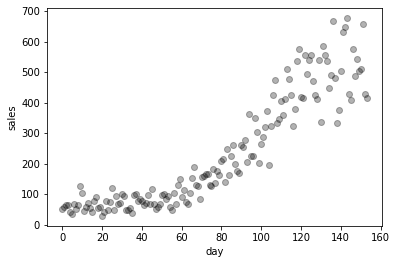

In [232]:
area_stat = dict()

for index, row in Transaction.iterrows():
    # compute sales of each day
    day = row['days_after_open']
    hour = row['hours_after_open']
    quality = row['quantity']
    drink = row['drink_id']
    area = row['study_area_id']
    unit_price = drink_price_getter[drink]
    if area not in area_stat:
        area_stat[area] = {}
    if day not in area_stat[area]:
        area_stat[area][day] = 0
    area_stat[area][day] += unit_price * quality

days_sale_area = []
day_labels_area = []

for day in area_stat[1]:
    days_sale_area.append(area_stat[1][day])
    day_labels_area.append(day)

plt.scatter(day_labels_area, days_sale_area, alpha=0.3, color='black')
plt.xlabel("day")
plt.ylabel("sales")

From the figures about business volume group by different regions (the above cell only shows one of them), we find each kind of coffee has a similar sales trend. The business volumes show a similar trend in different regions, which means the number of days since the pop-up store opened affects coffees' sales in different regions.

## Compute and draw the trend of daily sales group by different weathers

Text(0, 0.5, 'hour')

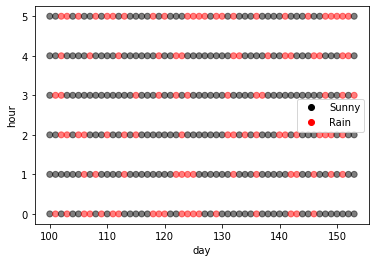

In [234]:
rain_stat = {}

for index, row in Transaction.iterrows():
    # compute sales of each day
    day = row['days_after_open']
    hour = row['hours_after_open']

    if day not in rain_stat:
        rain_stat[day] = {}
    if hour not in rain_stat[day]:
        rain_stat[day][hour] = {'rain':0, 'sunny':0}
    if row['raining'] == 'Yes':
        rain_stat[day][hour]['rain'] += 1
    elif row['raining'] == 'No':
        rain_stat[day][hour]['sunny'] += 1

weather_mat = []

for day in rain_stat:
    for hour in rain_stat[day]:
        if rain_stat[day][hour]['rain'] > rain_stat[day][hour]['sunny']:
            weather_mat.append({'day': day, 'hour': hour, 'rain': 1})
        else:
            weather_mat.append({'day': day, 'hour': hour, 'rain': 0})

weather_df = pd.DataFrame(weather_mat, columns = ['day', 'hour', 'rain']) 
labels = {'Sunny': 0, 'Raining': 1}
cmap = colors.LinearSegmentedColormap.from_list("", ["black","red"])

fig, ax = plt.subplots()
scatter = ax.scatter(weather_df['day'][100*6:], weather_df['hour'][100*6:], 
    c=weather_df['rain'][100*6:], cmap=cmap, alpha=0.5)

legend_elements = [Line2D([0], [0], marker='o', lw=0, color='black', label='Sunny'),
                   Line2D([0], [0], marker='o', lw=0, color='red', label='Rain')]

ax.legend(handles=legend_elements)
ax.set_xlabel("day")
ax.set_ylabel("hour")

As for the reason why the sales growth rate stabilized after the 135th day, we plot the weather situation each day after the 100th day. From this figure, it is clear that there is no extreme weather during these days. Hence the weather does not affect the macro trend of coffee sales.

In [237]:
# compute the correlation coefficient between days and scales

keys = day_sales.keys()
values = day_sales.values()

def cov(X, Y):
    sum = 0
    for i in range(len(X)):
        d = (X[i] - mean(X)) * (Y[i] - mean(Y))
        sum += d
    sum *= 1/(len(X)-1)
    return sum

def corr(X, Y):
    return cov(X, Y) / (stdev(X) * stdev(Y))

cc = corr(list(keys), list(values))

print('Pearsons correlation: %.3f' % cc)

Pearsons correlation: 0.932


We also compute the Pearsons correlation coefficient between day number and business volumes. The result indicates the high correlation between day numbers and business volumes.

## Further work

From the above exploration, we found the sales keep growing due to the coffee shop is gradually being exposed in the early stage, and also bringing in many new customers. When the exposure reaches its peak, the sales growth rate is approaching 0. Therefore, we can say the attribute “number of days since the pop-up store opened” affects the coffee sales, but it may not affect the sales in the future. As a result, for the sales prediction, we don’t recommend using “number of days since the pop-up store opened” to predict future sales.